In [1]:
import numpy as np
import cPickle
import soundfile
import scipy.signal as dsp
import copy

In [2]:
import gammatone.filters as gt_filters

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data structure

Onset
- position of this onset
- position of corresponding offset
- position of next onset

In [4]:
class Onset:
    def __init__(self,pos,next_pos,off_pos):
        self.pos = pos
        self.next_pos = next_pos
        self.off_pos = off_pos

Offset
- position of this offset
- weight of this offset(diff value)
- position of next offset

In [5]:
class Offset:
    def __init__(self,pos,weight,next_pos):
        self.pos = pos
        self.weight = weight
        self.next_pos = next_pos

OnsetFront
 - onset_pos_all: onset positon of all frequency channels
 - offset_pos_all: offset position of all frequency channels
 - chan_s: start channel
 - chan_e: end channel

In [6]:
class OnsetFront:
    def __init__(self,onset,chan):
        chan_num = 128
        self.pos_all = np.ones(chan_num,dtype=np.int32)*(2**31)
        self.pos_all[chan] = onset.pos

        if self.pos_all[chan]<0:
            raise Exception('OnsetFront init')
        
        self.off_pos_all = np.ones(chan_num,dtype=np.float32)*(-1)
        self.off_pos_all[chan] = onset.off_pos
        
        self.chan_s = chan
        self.chan_e = chan

    def update(self,onset,chan):
        self.pos_all[chan] = onset.pos
        self.off_pos_all[chan] = onset.off_pos
        
        if self.pos_all[chan]<0:
            raise Exception('OnsetFront update')
            
        if chan == self.chan_s-1 or chan == self.chan_s:
            self.chan_s = chan
        elif chan == self.chan_e+1 or chan == self.chan_e:
            self.chan_e = chan
        else:
            print self.chan_s,self.chan_e,chan
            raise Exception('wrong chan when updat onset_front')

    def update_pos(self,onset_pos,offset_pos,chan):
        
        self.pos_all[chan] = onset_pos
        self.off_pos_all[chan] = offset_pos
        
        if self.pos_all[chan]<0:
            raise Exception('OnsetFront update')
    
        if chan >= self.chan_s-1 and chan <= self.chan_e+1:
            self.chan_s = min(chan,self.chan_s)
            self.chan_e = max(chan,self.chan_e)
        elif chan >= self.chan_s and chan <= self.chan_e :
            print self.chan_s,self.chan_e,chan
            raise Exception('wrong chan when updat onset_front')

OnsetFront
- onset_pos_all: onset positon of all frequency channels
- offset_pos_all: offset position of all frequency channels
- chan_s: start channel
- chan_e: end channel

In [7]:
class OffsetFront:
    def __init__(self,offset,chan):
        
        chan_num = 128
        self.pos_all = np.zeros(chan_num,dtype=np.float32)-1
        self.pos_all[chan] = offset.pos
        if self.pos_all[chan]<0:
            raise Exception('OffsetFront init')
        
        self.chan_s = chan
        self.chan_e = chan
    
    def update(self,offset,chan):
        self.pos_all[chan] = offset.pos
        
        if self.pos_all[chan]<0:
            raise Exception('OffsetFront update')
        
        if chan == self.chan_s-1 or chan == self.chan_s:
            self.chan_s = chan
        elif chan == self.chan_e+1 or chan == self.chan_e:
            self.chan_e = chan
        else:
            print self.chan_s,self.chan_e,chan
            raise Exception('wrong chan when updat offset_front')
    
    
    def update_pos(self,offset_pos,chan):
        
        self.pos_all[chan] = offset_pos
        
        if chan >= self.chan_s-1 and chan <= self.chan_e+1:
            self.chan_s = min(chan,self.chan_s)
            self.chan_e = max(chan,self.chan_e)
        elif chan >= self.chan_s and chan <= self.chan_e :
            print self.chan_s,self.chan_e,chan
            raise Exception('wrong chan when updat offset_front')

# Auditory peripheral

In [8]:
def AudiPeriph(wav,fs):
    """gammatone filters
       max_cf: 8 kHz
       min_cf: 50 Hz
    """
    
    if len(wav.shape) > 1:
        wav = wav[:,0]
    
    cf_low = 50
    cf_high = 8000
    filter_num = 128
    
    cfs = gt_filters.erb_space(low_freq=cf_low,high_freq=cf_high,num=filter_num)
    cfs = np.flipud(cfs)
    fcoefs = gt_filters.make_erb_filters(centre_freqs=cfs,fs=fs,width=1.019)
    
    specgram = gt_filters.erb_filterbank(wave=wav,coefs=fcoefs)
    
    return specgram.T

In [9]:
def ExtracEnv(wav,fs):
    """extract envelope
        wav: [wav_len, channel_num]
    """
    
    wav_len,chan_num = wav.shape
    # half-wav rectified
#     wav[wav<0] = 0
    
    # band pass filter
    # kaiser filter
    band_p = 30
    band_s = 60
    order, beta = dsp.kaiserord(ripple=40,width=(band_s-band_p)/(0.5*fs))
    delay = int(order/2.0)
    fcoef = dsp.firwin(order, band_s, window=('kaiser', beta), nyq=0.5*fs)
    wav_lowpass = dsp.lfilter(b=fcoef,
                              a=1,
                              x=np.concatenate((np.abs(wav[delay:]),np.zeros((delay,chan_num))),axis=0),
                              axis=0)
    
    # downsample
    env_fs = 400
    step = int(fs/env_fs)
    env = wav_lowpass[xrange(0,wav_len,step)]
    
    
    plt_flag = False
    if plt_flag:
        #low pass filter
        plt.figure()
        freq,resp = dsp.freqz(fcoef,worN=10000)
        plt.plot(freq/np.pi*fs/2,20*np.log10(np.abs(resp)))
        plt.xlim([0,100])
        plt.xlabel('std frequency')
        plt.ylabel('gain(dB)')

        plt.figure();
        plt.plot(fcoef)
    
    return 10*np.log10(np.abs(env)+1)  # why not 20*log10

# Smooth in time and frequency scale

In [10]:
def Smooth(env,scale_t,scale_f):
    """smooth envelope in time and frequency scale orderly"""
    env_fs = 400
    chan_num = 128
    
    # smooth in time scale
    # kaiser filter
    band_p = scale_t
    band_s = scale_t + 10
    order,beta = dsp.kaiserord(ripple=40,width=(band_s-band_p)/(env_fs*0.5))
    delay = int(order/2)
    kaiser_b = dsp.firwin(order,(band_p+band_s)*0.5,window=('kaiser',beta),nyq=0.5*env_fs)
    
    env_tsmoothed = dsp.lfilter(b=kaiser_b,
                                a=1,
                                x=np.concatenate((env[delay:],np.zeros((delay,chan_num))),axis=0),
                                axis=0)
    
    
    
    # smooth in frequency scale
    # Gaussian window
    win_len = np.floor(scale_f*8+1)
    win = 1.0/(np.sqrt(2*np.pi)*scale_f)*np.exp(-(np.arange(win_len)-np.floor(win_len/2))**2/(scale_f**2))
    win = np.reshape(win,[-1,1])
    env_fsmoothed = dsp.convolve2d(env_tsmoothed,win,mode='same')
    
    if False:
        plt.figure()
        plt.subplot(121); 
        freq,resp = dsp.freqz(kaiser_b,worN=1000)
        plt.plot(freq,np.log10(np.abs(resp)))
        plt.subplot(122); plt.plot(win)
    
    return env_tsmoothed

# EdgeDetect

In [11]:
def PickOnset(intensity_diff,theta):
    """x two dimension array sample_num*channel_num
       return  onset_all: a list, each ele corresponding to a frequency channel, which is
       a list of Onset object
    """
    
    sig_len, channel_num = intensity_diff.shape

    diff_back = intensity_diff[1:-1] - intensity_diff[0:-2]
    diff_forw = intensity_diff[1:-1] - intensity_diff[2:]
    
    
    onset_all = []
    for chan in xrange(channel_num):
        peak_pos_all = np.squeeze(np.nonzero(np.logical_and(diff_back[:,chan]>0,diff_forw[:,chan]>0))[0])+1
        onset_pos_all = peak_pos_all[intensity_diff[peak_pos_all[:],chan]>theta]

        if onset_pos_all.shape[0] < 1:
            raise Exception('fail to extract onset on channel %d'%chan)
        onset_chan = [Onset(int(onset_pos),-1,-1) for onset_pos in onset_pos_all]
        onset_all.append(onset_chan)
    
    for onset_chan in onset_all:
        for i in xrange(1,len(onset_chan)):
            onset_chan[i-1].next_pos = onset_chan[i].pos
        onset_chan[-1].next_pos = int(sig_len-1)
        
    if False:
        plt.figure()
        plt.plot(intensity_diff[:,0],'x')
        plt.plot(0,theta,'ro')
#         print theta
        raise Exception('pick onset')
        
    return onset_all


def PickOffset(intensity_diff,theta):
    """ """
    channel_num = intensity_diff.shape[1]
    
    diff_back = intensity_diff[1:-1] - intensity_diff[0:-2]
    diff_forw = intensity_diff[1:-1] - intensity_diff[2:]
    
    offset_all = []
    for chan in xrange(channel_num):

        valley_pos_all = np.squeeze(np.nonzero(np.logical_and(diff_back[:,chan]<0,diff_forw[:,chan]<0)))+1
        offset_pos_all = valley_pos_all[intensity_diff[valley_pos_all,chan]<theta]
        if offset_pos_all.shape[0] < 1:
            raise Exception('fail to extract onset on channel %d'%chan)
            
        offset_chan = [Offset(int(offset_pos),intensity_diff[offset_pos,chan],-1) 
                       for offset_pos in offset_pos_all]
        
        offset_all.append(offset_chan)
        
    return offset_all


def EdgeDetect(env,para = 1):
    """detecte candidate onset and offset"""
    
    # first difference
    env_diff = env[1:]-env[:-1]
    
    # onset 
    diff_mean = np.mean(np.mean(env_diff[60:-60],axis=0))
    diff_std = np.mean(np.std(env_diff[60:-60],axis=0))
    
    # 
    onset_theta = diff_mean+para*diff_std
    
    onset_all = PickOnset(env_diff,onset_theta)
    # offset
    offset_theta = 100
    offset_all = PickOffset(env_diff,offset_theta)
    
    return [onset_all,offset_all]

In [12]:
def UpdateSegPos(segs,onset_all,offset_all):
    """Corresponding precisePosition, but I think 'update' is more suitable. In summary, 
    onset and offset estimated in current scale is used to update the onset and offset of
    segments if they are close enough"""
    
    segs_num = len(segs)
    if segs_num < 1:
        return
    
    m_dis = 8 # 

    for seg in segs:
        chan_s = seg.chan_s
        chan_e = seg.chan_e
        for chan in xrange(chan_s,chan_e+1):
            # update onset
            seg_onset_pos = seg.pos_all[chan]
            dis = [np.abs(seg_onset_pos-onset.pos) for onset in onset_all[chan]]
            min_dis_i = np.argmin(dis)
            if  dis[min_dis_i] < m_dis:
                
                seg.pos_all[chan] = onset_all[chan][min_dis_i].pos
                if seg.pos_all[chan] < 0:
                    raise Exception('UpdateSegPos')
            
            # update offset
            seg_offset_pos = seg.off_pos_all[chan]
            dis = [np.abs(seg_offset_pos-offset.pos) for offset in offset_all[chan]]
            min_dis_i = np.argmin(dis)
            if  dis[min_dis_i] < m_dis and offset_all[chan][min_dis_i].pos>seg.pos_all[chan]:
#                 print 'seg.off_pos', seg.off_pos_all[chan],offset_all[chan][min_dis_i].pos, dis[min_dis_i],m_dis
                seg.off_pos_all[chan] = offset_all[chan][min_dis_i].pos
#         print seg.pos_all,seg.off_pos_all

In [13]:
def CorrCoef(x1,x2):
    """correlate coefficient of two given channels"""
    x1 = np.reshape(x1,newshape=[-1,1])
    x2 = np.reshape(x2,newshape=[-1,1])
#     print x1.shape, x2.shape
    energy_x1 = np.dot(x1.T,x1)
    energy_x2 = np.dot(x2.T,x2)

    if (energy_x1==0) or (energy_x2==0):
        r = 0
    else:
        r = np.dot(x1.T,x2)/(np.sqrt(energy_x1*energy_x2))
    return r

In [14]:
def my_min(x):
    min_i = np.argmin(x)
    return [x[min_i],min_i]

def MatchOFset(ofset_chan,pos,m_dis=8,m_pos=0):
    """
    find onset/offset closest to pos in OFset_chan and the distance should be smaller than m_dist
    """
    set_dis = [np.abs(pos-ofset.pos) for ofset in ofset_chan]
    min_dis,min_i = my_min(set_dis)
    if (min_dis<m_dis) and (ofset_chan[min_i].pos>m_pos): 
        return min_i
    return -1

# Multi-scale merge

In [15]:
def ExpandFreq2(env,chan_bound,chan_new,seg,onset_all,offset_all,theta_c):
    """sub function of ExpandFreq
        chan_bound: current boundary channel of the seg
        chan_new: channel need to be checked whether it should be included in the seg
        pos_bound: the onset time of chan_bound
        theta_c: theshold of cross-channel similarity
        
    """
    m_dis = 8
    
    pos_s = int(seg.pos_all[chan_bound])
    pos_e = int(seg.off_pos_all[chan_bound])
    
#     print pos_s,pos_e, CorrCoef(env[pos_s:pos_e+1,chan_bound],env[pos_s:pos_e+1,chan_new]) ,theta_c
    if CorrCoef(env[pos_s:pos_e+1,chan_bound],env[pos_s:pos_e+1,chan_new]) > theta_c:
        # Fist search the nearest onset in chan_bound
        onset_i_b = MatchOFset(onset_all[chan_bound],pos_s,m_dis)
        if onset_i_b > -1:
            # Then search the nearest onset in chan_new
            onset_i_n = MatchOFset(onset_all[chan_new],onset_all[chan_bound][onset_i_b].pos,m_dis)
            if onset_i_n > -1:
                # find correspond offset for the new seg bound
                # One additional condition: offset_pos > onset_pos
                # since m_dis is set to 8, the seg lenght could maximumly decrease 16
                offset_i_n = MatchOFset(offset_all[chan_new],pos_e,m_dis,seg.pos_all[chan_new] )
                if offset_i_n > -1:
#                     print 'place1'
                    seg.update_pos(onset_all[chan_new][onset_i_n].pos,
                                   offset_all[chan_new][offset_i_n].pos,
                                   chan_new)
                    
                return True # Succed in expanding
                     
    return False


def ExpandFreq(env,segs,onset_all,offset_all,theta_c):
    """expand the frequency boudnary of existed segments if 
       1) corss-channel similarity is small, threshold theta_c
       2) onsets are close, m_dis = 8 
       """
    segs_num = len(segs)
    if segs_num < 1:
        return

    chan_num = 128
    for seg in segs:
        # upward
        chan_bound = seg.chan_e
        while((chan_bound<chan_num-1) and ExpandFreq2(env,chan_bound,chan_bound+1,seg,onset_all,offset_all,theta_c)):
            chan_bound = chan_bound + 1

        # downward
        chan_bound = seg.chan_s
        while((chan_bound>0) and ExpandFreq2(env,chan_bound,chan_bound-1,seg,onset_all,offset_all,theta_c)):
#             print seg.chan_s,chan_bound
            chan_bound = chan_bound - 1    
    
    ## merge segs if they have **the same onset times** in at least one channel
    # why onset times should be exactly the same ? 
    seg_i_1 = 0
    while seg_i_1 < len(segs)-1:
        chan_s = segs[seg_i_1].chan_s
        chan_e = segs[seg_i_1].chan_e
        
        seg_i_2 = seg_i_1+ 1
        while seg_i_2 < len(segs):
            onset_pos_1 = segs[seg_i_1].pos_all[chan_s:chan_e+1] 
            onset_pos_2 = segs[seg_i_2].pos_all[chan_s:chan_e+1]
            if np.min(np.abs(onset_pos_1-onset_pos_2)) == 0:
#                 print seg_i_1,seg_i_2,onset_pos_1,onset_pos_2
                MergeSegs(segs,seg_i_1,seg_i_2)
                seg_i_2 = seg_i_1 + 1 # since seg_i_1 is already changed, search for 
                                      # seg to be merged will start over
            else:
                seg_i_2 += 1

        seg_i_1 += 1
        
    
def MergeSegs(segs,seg_i_1,seg_i_2):
    """ 
    merge seg_i_2 to seg_i_1, and delte seg_i_2
    """

    all_chan_s = min(segs[seg_i_1].chan_s,segs[seg_i_2].chan_s)
    all_chan_e = max(segs[seg_i_1].chan_e,segs[seg_i_2].chan_e)
    
#     print 'place2'
    
    for chan in xrange(segs[seg_i_1].chan_s-1,all_chan_s-1,-1):
        segs[seg_i_1].update_pos(segs[seg_i_2].pos_all[chan],
                                 segs[seg_i_2].off_pos_all[chan],
                                 chan)
        
    for chan in xrange(segs[seg_i_1].chan_s,segs[seg_i_1].chan_e+1):
        onset_pos = min(segs[seg_i_1].pos_all[chan],segs[seg_i_2].pos_all[chan])
        offset_pos = max(segs[seg_i_1].off_pos_all[chan],segs[seg_i_2].off_pos_all[chan])
        segs[seg_i_1].update_pos(segs[seg_i_1].pos_all[chan],
                                 segs[seg_i_1].off_pos_all[chan],
                                 chan)
    
    for chan in xrange(segs[seg_i_1].chan_e+1,all_chan_e+1):
        segs[seg_i_1].update_pos(segs[seg_i_2].pos_all[chan],
                             segs[seg_i_2].off_pos_all[chan],
                             chan)
    segs.pop(seg_i_2)

In [16]:
def PruneOnset(env,segs,onset_all):
    """Onset is deleted if it is embodied in a existed segment"""
    ## ? what about offset ?
    
    seg_num = len(segs)
    if seg_num <1:
        return
    
    match_mask = np.zeros_like(env,dtype=np.bool) # indicator whether a TF unit belongd to a segment
    
    for seg in segs:
        for chan in xrange(seg.chan_s,seg.chan_e+1):
            match_mask[int(seg.pos_all[chan]):int(seg.off_pos_all[chan]+1),chan]=1
    
    chan_num = 128
    for chan in xrange(chan_num):
        index = np.nonzero([np.logical_not(match_mask[onset.pos,chan]) 
                                       for onset in onset_all[chan]])[0]
#         print index
        if index.shape[0] >0:
#             print index,index.shape,type(index),index.dtype,type(index[0])
            onset_all[chan] = [onset_all[chan][index[i]] for i in xrange(len(index))] 
            # only preserve onset not in any segment

# Onset and offset match

In [17]:
def MatchOnOff(onset_all,offset_all):
    """In each frequency channel, match a offset for each onset
    matching rule:
        1) pos should be in the range [onset.pos onset.next_pos]
        2) minumum intensity difference
    """
    chan_num = 128
    for chan in xrange(chan_num):
        for onset in onset_all[chan]:
            matched_offset_chan = [offset
                              for offset in offset_all[chan]
                              if (offset.pos>onset.pos and offset.pos<onset.next_pos)]
            if len(matched_offset_chan) < 1:
                onset.off_pos = onset.next_pos-1  # ? if no 
            else:
                min_weight_i = np.argmin([offset.weight for offset in matched_offset_chan])
#                 print 'match onset offset', len(matched_offset_chan),min_weight_i,[offset.weight for offset in matched_offset_chan]
                onset.off_pos = matched_offset_chan[min_weight_i].pos
                

# Extract the onset/offset front

In [18]:
def ExtractOFsetFront(ofset_all,theta,is_offset_front=1,env=[]):
    """ Extract onset/offset front, corresponding to "onsetFront" and "offsetFront" two function
        Rules of onset/offset front extraction
        1) cross channel similarity (only for onset front)
        2) onset distance (shared)
    """
    
    mark  = np.zeros((2,np.max([len(ofset_chan) for ofset_chan in ofset_all])),dtype=np.int16)

    m_dis = 8
    chan_num = 128
    
    front_all = []
    front_count = 0
    init_funcs = [OnsetFront,OffsetFront]
    
#     print 'is_offset_front',is_offset_front
#     print 'begin'
    for chan in xrange(chan_num):
        if chan > 0: # update the id of onset_front (mark[0] = mark[1])
            mark[0,:] = mark[1,:]
            mark[1,:] = 0
            
        for ofset_i, ofset in enumerate(ofset_all[chan]):
            index = -1
#             print env[ofset.pos:ofset.next_pos+1,chan].shape
            if (chan>0) and (is_offset_front or (CorrCoef(env[ofset.pos:ofset.next_pos+1,chan],env[ofset.pos:ofset.next_pos+1,chan-1])> theta)):

                index = MatchOFset(ofset_all[chan-1],ofset.pos,m_dis)
#                 print index
                
            if index > -1: # find a match then update exist onset front
                mark[1][ofset_i] = mark[0][index]
                front_all[int(mark[1,ofset_i])].update(ofset,chan)
#                 print
#                 if front_all[int(mark[1,ofset_i])].pos_all[chan-1] != ofset_all[chan-1][index].pos:
#                     print front_all[int(mark[1,ofset_i])].pos_all[chan-1],ofset_all[chan-1][index].pos,mark[1,ofset_i],index
#                     raise Exception('here0')
    
#                 if np.abs(ofset.pos-front_all[int(mark[1,ofset_i])].pos_all[chan-1]) > 8:
#                     print ofset.pos, front_all[int(mark[1,ofset_i])].pos_all[chan-1],ofset_all[chan-1][index].pos,mark[1][ofset_i],index
#                     print mark[0,:]
#                     raise Exception('here')
#                 print front_all[int(mark[1][ofset_i])].chan_s,front_all[int(mark[1][ofset_i])].chan_e
#                 raise Exception('test2')
#             if ofset_i>0 and mark[0][index] == mark[1][ofset_i-1]:
#                 new_font = copy.deepcopy(front_all[mark[1][ofset_i-1]])
#                 new_font.update(ofset,chan)
#                 front_all.append(new_font)
#                 front_count += 1
#                 mark[1,ofset_i] = front_count-1
            else:
                # create new onset front
                front_count += 1
                mark[1,ofset_i] = front_count-1
                front_all.append(init_funcs[is_offset_front](ofset,chan))
#             print 'iter', mark[1,:],front_count

    if len(front_all) != front_count:
        raise Exception('front_all: wrong size')
        
    # onset fronts with occupied frequency channel less than or equal to 3 will be deleted

    if is_offset_front:
        i = 0
        while i < front_count:
            if front_all[i].chan_e <= front_all[i].chan_s:
                front_all.pop(i)
                front_count -= 1
            i+=1
    else:
        i = 0
        while i < front_count:
            if front_all[i].chan_e - front_all[i].chan_s <= 3:
                front_all.pop(i)
                front_count -= 1
            i += 1
    return front_all

# Match onset front with offset front

In [19]:
def my_max(x):
    
    max_i = np.argmax(x)
    return [x[max_i],max_i]


def MatchChanNum(seg,offset_front,mark):
    """Count the number of chanels in which offset_front pos is equal
    the offset pos matched to onset_front"""
    chan_s = max(seg.chan_s,offset_front.chan_s)
    chan_e = min(seg.chan_e,offset_front.chan_e)
#     print  id(seg)
    
    if False:
        plt.figure()
        plt.plot(seg.off_pos_all[seg.chan_s:seg.chan_e+1],
             np.arange(seg.chan_s,seg.chan_e+1),'r',linewidth=2)

        plt.plot(offset_front.pos_all[offset_front.chan_s:offset_front.chan_e+1],
                np.arange(offset_front.chan_s,offset_front.chan_e+1),'b',linewidth=1)

        plt.xlim([0,1200])
        
    same_offset_flag = np.equal(seg.off_pos_all[chan_s:chan_e+1],
                            offset_front.pos_all[chan_s:chan_e+1])
    
    return np.count_nonzero(np.logical_and(same_offset_flag,mark[chan_s:chan_e+1]))



def PredictOffset(seg,mark):
    """estimat offsets in matched frequency channels"""
    
    # find matched channels range
    match_chan_s = seg.chan_s
    match_chan_e = seg.chan_e
    while match_chan_s<match_chan_e and mark[match_chan_s]==1:
        match_chan_s += 1
    while match_chan_e>match_chan_s and mark[match_chan_e]==1:
        match_chan_e -= 1

    # non channel is matched
    if match_chan_s == match_chan_e: 
        for chan in xrange(seg.chan_s,seg.chan_e+1):
            seg.off_pos_all[chan] = seg.off_pos_all[match_chan_s]
        return
    
    # only part of channels are unmatched, two conditions
    # 1) unmatched channel between matched channels (seems to be impossible)
    chan=match_chan_s
    state = 0
    chan1 = 0; chan2 = 0
    while chan < match_chan_e:
        
        if mark[chan]==0 and state==0: # find fist matched channel
            state=1
            chan1 = chan
        elif mark[chan]==0 and state==1: # find second matched channel
            chan2 = chan
            slope = (seg.off_pos_all[chan2]-seg.off_pos_all[chan1])/(chan2-chan1)
            
            for unmatch_chan in xrange(chan1,chan2):
                seg.off_pos_all[unmatch_chan] = seg.off_pos_all[chan1]+(unmatch_chan-chan1)*slope
                
            chan1=chan2
            state=0
        
        elif mark[chan]==1:# find a unmatched channel, enter preparation 
            state = 1

        chan +=1
            
    # 2) umatched channel at begining and ending
    seg.off_pos_all[seg.chan_s:match_chan_s] = seg.off_pos_all[match_chan_s]
    seg.off_pos_all[match_chan_e+1:seg.chan_e] = seg.off_pos_all[match_chan_e]
    


def MatchOFFront(segs,onset_front_all,offset_front_all):
    """
    Matching rule:
        1. Selects all the offset fronts that cross at least one of these offset times.
        2. The offset front that across the most of the these offset times is chosen as 
           the matching offset front
        3. All channels occupied by the matching offset front are labeled as "matched" 
           and their offset times are updated according to the matching offset front
        4. This process repeats until all channels from $c$ to $c+m-1$ are labeled as matched

    """
    chan_num = 128
    
    for onset_front_i,onset_front in enumerate(onset_front_all):
        
        seg = copy.deepcopy(onset_front)
        
        mark = np.zeros(chan_num)
        mark[seg.chan_s:seg.chan_e] = 1 # 1 for unmactched 
        unmatch_chan_num = seg.chan_e - seg.chan_s + 1
        
        while(unmatch_chan_num>0):
            # check shared frequency channel number
            match_chan_num_all = [MatchChanNum(seg,offset_front,mark) 
                                  for offset_front in offset_front_all]
            # find offset front with the most shared channels
            max_chan_num,offset_front_i = my_max(match_chan_num_all)
#             print offset_front_i
            if max_chan_num > 0: # find a matched offset
                match_offset_front = offset_front_all[offset_front_i]
                
                # shared frequency channels
                chan_s = max(seg.chan_s,match_offset_front.chan_s)
                chan_e = min(seg.chan_e,match_offset_front.chan_e)
                # mark this channel as matched
                mark[chan_s:chan_e+1] = 0
                # Add matched offset_front to seg
                seg.off_pos_all[chan_s:chan_e+1]=match_offset_front.pos_all[chan_s:chan_e+1]
                
                unmatch_chan_num -=(chan_e-chan_s+1)
            else:
                PredictOffset(seg,mark)
                unmatch_chan_num = 0
        
        
        segs.append(seg)
        
        
        #         plt.figure(figsize=[12,4]);
        if False:
            plt.figure()
            plt.subplot(121); plt.imshow(env_smoothed.T,aspect='auto',origin='lower')
            plt.subplot(122); plt.imshow(X=env.T,aspect='auto',origin='lower')
    #         for seg1 in segs:
            plt.plot(seg.pos_all[seg.chan_s:seg.chan_e+1],
                     np.arange(seg.chan_s,seg.chan_e+1),'ro',linewidth=2)

            plt.plot(onset_front.off_pos_all[seg.chan_s:seg.chan_e+1],
                     np.arange(seg.chan_s,seg.chan_e+1),'bo',linewidth=2)

            plt.plot(seg.off_pos_all[seg.chan_s:seg.chan_e+1],
                     np.arange(seg.chan_s,seg.chan_e+1),'kx',linewidth=2)
            plt.title('%d'%onset_front_i)

# All together

In [20]:
def Segregation(wav,fs):

    # Auditory filter bank
    audiogram = AudiPeriph(wav,fs)

    # # Envelope 
    env = ExtracEnv(audiogram,fs)

    segs = []

    scale_t_all = np.asarray([4,14,14],dtype=np.float32)
    scale_f_all = np.asarray([6,6,0.5])
    scale_type_all = np.asarray([1,1,0])
    theta_c_all = np.asarray([0.95,0.95,0.85],dtype=np.float32)

    for scale_i in xrange(0,3):

        print scale_i

        # Time smooth
        env_smoothed = Smooth(env,scale_t_all[scale_i],scale_f_all[scale_i])

        # Edge detection
        [onset_all,offset_all] = EdgeDetect(env_smoothed,para=1.8)

        ## Multi-scale merge        
        # update the onset and offset position of existed segs
        UpdateSegPos(segs,onset_all,offset_all)

        # extend the occupied channels of existed segs
        ExpandFreq(env_smoothed,segs,onset_all,offset_all,theta_c_all[scale_i])


        # delete onset which is embodied in existing segs 
        PruneOnset(env,segs,onset_all)

        if scale_type_all[scale_i] == 1:
            # Match offset for each onset, for offset_front matching 
            MatchOnOff(onset_all,offset_all)

            # Onset front / offset front
            print 'onset_front_all'
            onset_front_all = ExtractOFsetFront(onset_all,theta_c_all[scale_i],is_offset_front=False,env=env)
            print 'offset_front_all'
            offset_front_all = ExtractOFsetFront(offset_all,theta_c_all[scale_i],is_offset_front=True)

            MatchOFFront(segs,onset_front_all,offset_front_all)



    # combine overlaped segments
    mark = np.zeros_like(env,dtype=np.int32)-1
    for seg_i,seg in enumerate(segs):
        for chan in xrange(seg.chan_s,seg.chan_e+1):
            for pos in xrange(int(seg.pos_all[chan]),int(seg.off_pos_all[chan]+1)):
                if mark[pos,chan] < 0 or seg.pos_all[chan] < segs[mark[pos,chan]].pos_all[chan]:
                    mark[pos,chan] = seg_i

    if True:
        mask = copy.deepcopy(mark)
        mask[mask+1>0] = 1
        plt.figure()
        plt.imshow(mask.T,aspect='auto',origin='lower'); plt.title('segment result')
        plt.figure(); plt.imshow(X=env.T,aspect='auto',origin='lower'); plt.title('envelope')

# Main

0
onset_front_all
offset_front_all
1
onset_front_all
offset_front_all
2


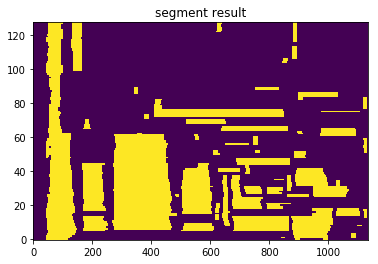

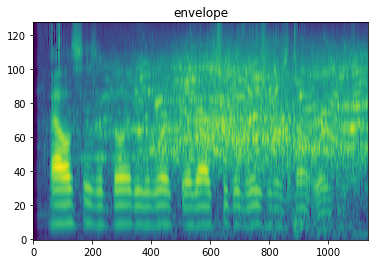

In [21]:
with file('input.dat','r') as input_file:
    wav = np.asarray([float(line) for line in input_file.readlines()])

Segregation(wav,20000)